<a href="https://www.kaggle.com/code/jaymanvirk/model-designs-impact-on-cnn?scriptVersionId=146187593" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Histopathologic Cancer Detection: Exploring architectural variations and hyperparameter impact on CNN

**Jay Manvirk (Ivan Loginov)**<br/>University of Colorado, Boulder<br/>jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per label](#chapter_4_2)
    - 4.3 [Images](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Sampling](#chapter_5_1)
    - 5.2 [Train-test split](#chapter_5_2)
    - 5.3 [Parallel preprocessing](#chapter_5_3)
6. [Model architecture](#chapter_6)
    - 6.1 [Base model](#chapter_6_1)
    - 6.2 [Base + Additional layers](#chapter_6_2)
    - 6.3 [Base + Wider layers](#chapter_6_3)
    - 6.4 [Base + Max pooling](#chapter_6_4)
    - 6.5 [Base + Dropout regularization](#chapter_6_5)
7. [Model results](#chapter_7)
    - 7.1 [Base model](#chapter_7_1)
    - 7.2 [Base + Additional layers](#chapter_7_2)
    - 7.3 [Base + Wider layers](#chapter_7_3)
    - 7.4 [Base + Max pooling](#chapter_7_4)
    - 7.5 [Base + Dropout regularization](#chapter_7_5)
    - 7.6 [Table results comparison](#chapter_7_6)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

This study briefly investigates the impact of different architectures and hyperparameters on the performance of convolutional neural networks (CNNs) through a comparative analysis of five distinct models. The research focuses on understanding how variations in the model design influence the models' ability to classify pathology images. The dataset utilized in this study comprises a substantial collection of small pathology images, categorized into two classes: images containing metastatic cancer and images devoid of it. By altering model configurations such as network depth, layer sizes, max pooling and dropout layer inclusion, the study explores the models' accuracy, efficiency, and generalization capabilities.

# 2. Introduction <a class="anchor" id="chapter_2"></a>

The goal of this notebook is to understand different architectures and hyperparameters effect on model by comparing performance of the 5 simple CNNs:

1. Base model, which is going to include convolutional, flatten and dense layers
2. Base + Additional layers
3. Base + Wider layers
4. Base + Max pooling
5. Base + Dropout regularization

Every specification presented here, except the first one, is a slight extension of the base model. With these examples we're aiming to descern the effects of the introduced designs on the model results. Concretely, we're going to measure models' runtime and train/test ROC AUC scores per epoch.

For the sake of boosting the training speed of the aforementioned models we're going to incorporate Tensorflow parallelism and GPU accelerators.

The notebook is going to be divided into several sections in order to achieve our goal:
* **Exploratory Data Analysis:**<br/>
As was mentioned in the preface of this dataset, the data has been already modified, so that it is duplicate-free. However, it's not enough to accept that data doesn't need any additional manipulation. Therefore we're going to look closer at the dataset internals for any additional cleaning or type conversion. Also we will examine the number of records per label to see whether the dataset needs sampling or not.
* **Data preprocessing:**<br/>
Here we will introduce 3 steps to improve future model trainings efficiency. Sampling, train-test split and parallel preprocessing.<br/>
In the Sampling section we will try to even number of records per label for better label representation during training. The train-test split section is presented only due to the reason, that we're not going to use cross validation. We will manually pass train and test sets directly to the models' fit function. And finally the first parallelism would be introduced in the parallel preprocessing section. It's going to be about how to utilize CPU cores efficiently to load images as fas as possible.
* **Model Architecture:**<br/>
Every model, except the base one, is going to be an updated version of the base model. In essence they are supposed to be simple and straightforward, so that it's easier to spot the impact of the different setups on the model. Another reason for the implemented simplicity is that this notebook doesn't take hours to run.
* **Model results comparison:**<br/>
This section is going to be filled with train/test scores per epoch charts and final table with the fitted models' runtime and the ROC AUC scores.

# 3. Libraries and data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [3]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Data preprocessing
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Convolutional neural network
from keras.models import Sequential
from tensorflow.keras import layers, models

# helper functions
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [2]:
# Print list of files and directories in folder
input_dir = '/kaggle/input/histopathologic-cancer-detection'
list_l = [os.path.join(input_dir, x) for x in os.listdir(input_dir)]
list_l

['/kaggle/input/histopathologic-cancer-detection/sample_submission.csv',
 '/kaggle/input/histopathologic-cancer-detection/train_labels.csv',
 '/kaggle/input/histopathologic-cancer-detection/test',
 '/kaggle/input/histopathologic-cancer-detection/train']

In [3]:
# Set datasets and directory names
sample_data = pd.read_csv(list_l[0])
train_data = pd.read_csv(list_l[1])
train_dir = list_l[3] + '/'
test_dir = list_l[2] + '/'

In [4]:
# Cleaning
del list_l

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

In [5]:
def print_short_summary(name, data):
    """
    Prints data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    
def print_number_files(dirpath):
    print('{}: {} files'.format(dirpath, len(os.listdir(dirpath))))

In [6]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

2. Data shape: (220025, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

2. Data shape: (57458, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


In [8]:
print_number_files(train_dir)

/kaggle/input/histopathologic-cancer-detection/train/: 220025 files


In [9]:
print_number_files(test_dir)

/kaggle/input/histopathologic-cancer-detection/test/: 57458 files


In [10]:
# Cleaning
del print_short_summary, print_number_files

## 4.2 Number of records per label <a class="anchor" id="chapter_4_2"></a>

The number of records per label differs signinficantly. This might shift model's focus a bit more towards the majority class resulting in lower ROC AUC score. Additionaly it create a problem in the model scoring, if only one class is present in the selected batch. We will address these problems in the 5.1 Sampling section.

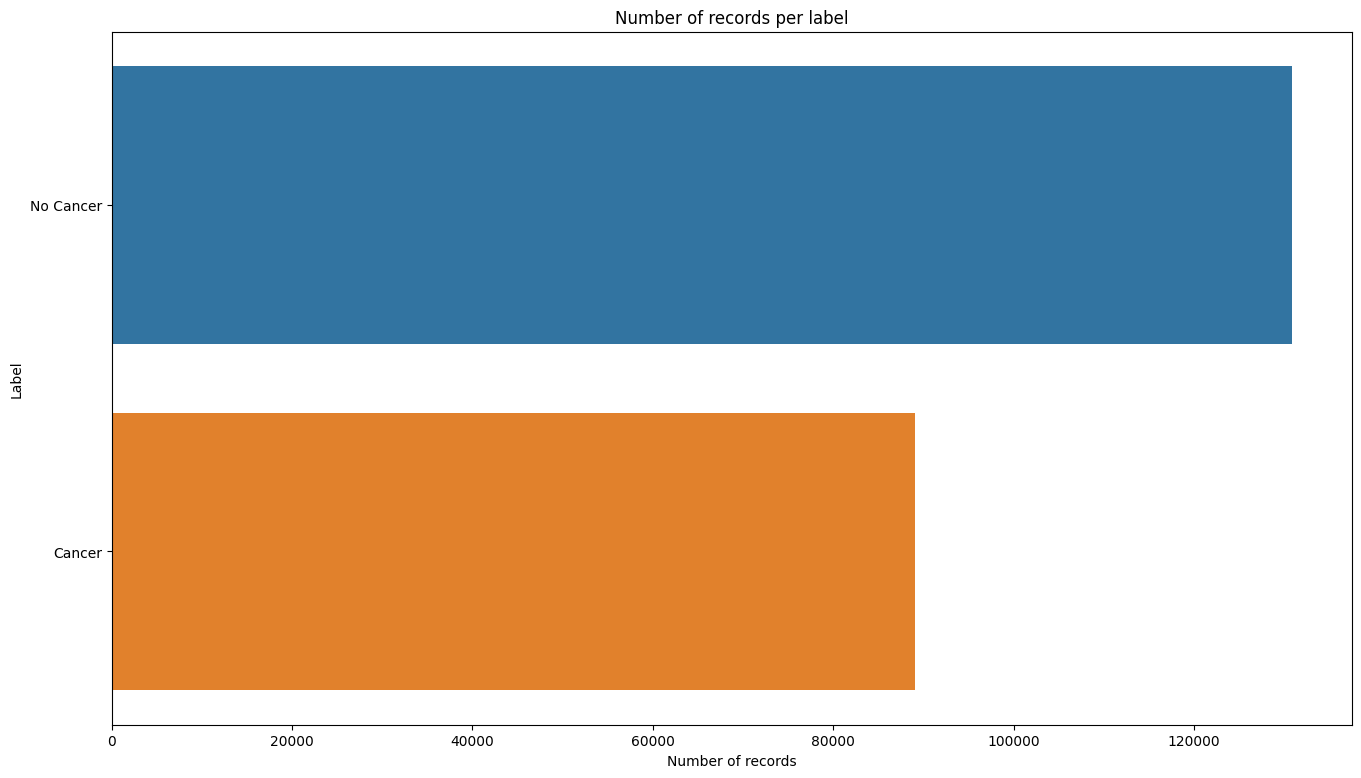

In [11]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['label'].value_counts()
sns.barplot(y=['No Cancer', 'Cancer'], x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()

In [12]:
# Cleaning
del tmp

## 4.3 Images <a class="anchor" id="chapter_4_3"></a>

In [13]:
def get_images_to_plot(file_names):
    """
    Returns list of images
    Args:
        file_names: list of filenames
    Returns:
        list of image objects
    """
    return [Image.open(f) for f in file_names]

def get_image_label(dirname, data, labels, n = 5):
    """
    Return dictionary with label-imagepath
    Args:
        dirname: name of the directory
        data: dataset of file names
        labels: list of labels
        n (opt): number of images per label
    Returns:
        dict_img: dictionary with label-imagepath pairs
    """
    dict_img = {}
    for l in labels:
        indexes = data['label'] == l
        tmp = data[indexes][:n]
        tmp = dirname + tmp['id'] + '.tif'
        tmp = tmp.values
        tmp = get_images_to_plot(tmp)
        dict_img[l] = tmp
        
    return dict_img

In [14]:
# Print original image size
img_path = train_dir + train_data['id'][0] + '.tif'
img = Image.open(img_path)
print('Original image size: {}'.format(img.size))

Original image size: (96, 96)


In [15]:
# Get 5 filenames per label
data = get_image_label(train_dir,train_data, [0,1])

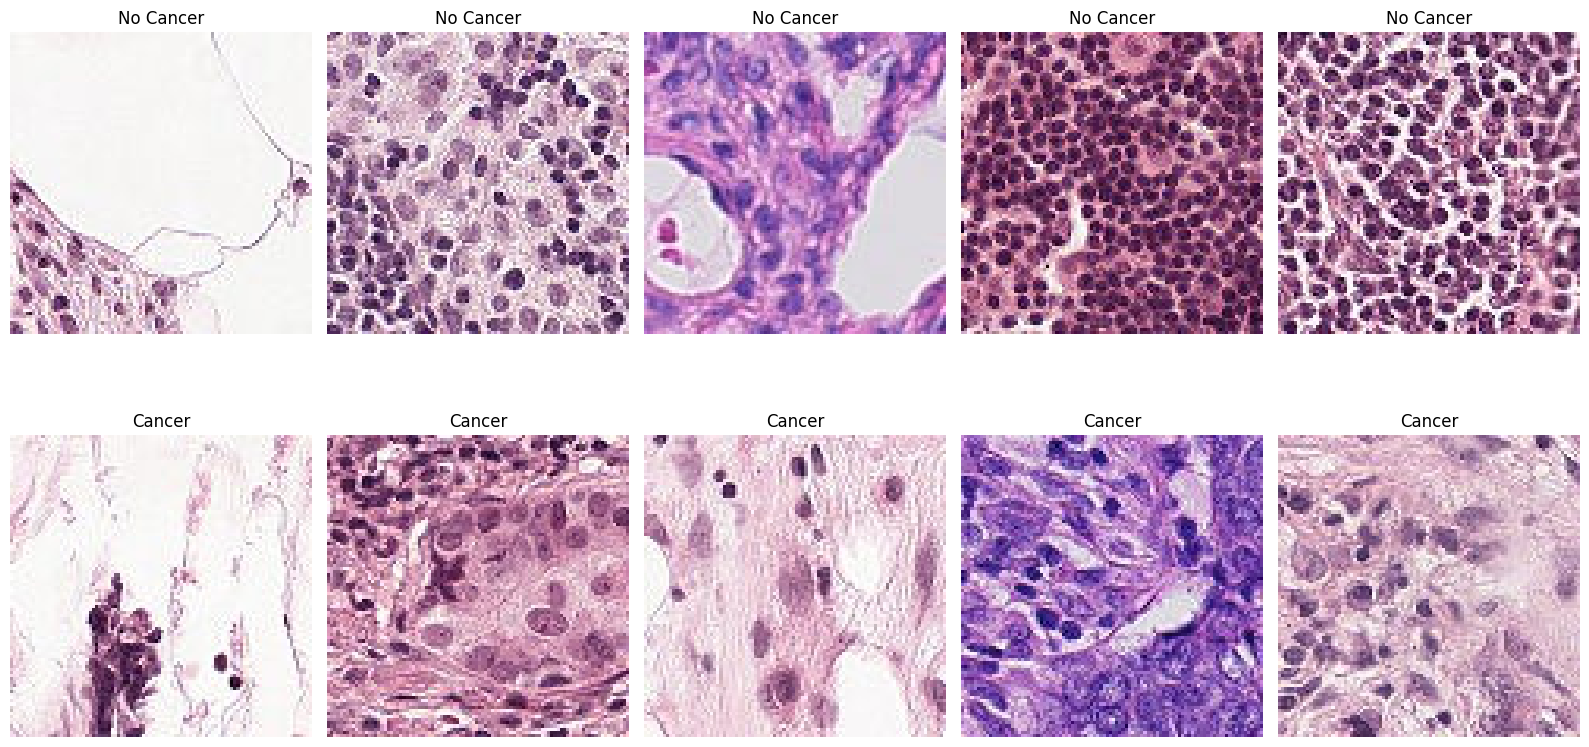

In [16]:
# Initialize subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))

# Loop through selected images and display in the respective rows
labels = ['No Cancer', 'Cancer']
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(data[row][col])
    axes[row, col].set_title(labels[row])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Cleaning
del get_images_to_plot, get_image_label, img_path, img
del data, fig, axes, labels, row, col

# 5. Data preprocessing <a class="anchor" id="chapter_5"></a>

## 5.1 Sampling <a class="anchor" id="chapter_5_1"></a>

Downsampling or upsampling are about bias-variance trade-off. In the first one we reduce the number of records from the majority class. In the second one we replicate existing instances of minority class. In both cases we're trying to:
* even number of labels to improve model performance, be it better generalization (upsample) or faster training (downsample)
* lower the risk of error in the ROC AUC score calculation if only one label is present in the selected batch

In our case the choice falls in favor of downsampling. Since we're dealing with simple CNN comparison our aim here is not the top performance algorithm. Thus we need to tune not just the models but the training data as well in order to reduce computational time as much as possible. Of course, all of that has to be done without significant loss in the ROC AUC score.

In [18]:
# Majority class
no_cancer = train_data[train_data['label'] == 0]
# Minority class
cancer = train_data[train_data['label'] == 1]

# Downsample majority class to match minority class
no_cancer_downsampled = resample(no_cancer,
                              replace=False, 
                              n_samples=len(cancer),
                              random_state=0)

balanced_train_data = pd.concat([no_cancer_downsampled, cancer])

# Shuffle train data for training
balanced_train_data = balanced_train_data.sample(frac=1, random_state=0).reset_index(drop=True)


In [19]:
# Cleaning
del no_cancer, cancer, no_cancer_downsampled

## 5.2 Train-test split <a class="anchor" id="chapter_5_2"></a>

Since we're not going to rely on cross validation, we need to provide both train and test samples to CNN to measure overfitting during training. Thus we first split our train dataset into 75% and 25% of train and test data respectively based on the default values of train_test_split function.

In [20]:
# Get full path to image including extension
image_paths = train_dir + balanced_train_data['id'] + '.tif'
image_paths = image_paths.values

labels = balanced_train_data['label'].values

X_train, X_test, y_train, y_test = train_test_split(image_paths
                                                    , labels
                                                    , test_size = 0.25
                                                    , shuffle = True
                                                    , random_state = 0)

In [21]:
# Cleaning
del image_paths, labels

## 5.3 Parallel preprocessing <a class="anchor" id="chapter_5_3"></a>

If we were to load images sequentially one-by-one, we would lose significant amount of time. Therefore it's more efficient to run this process in parallel in batches, so that most of the time would be spent on the actual training. With that in mind we're going to incorporate Tensorflow parallel processing functions to use optimal number of CPU cores provided in this notebook.

Additional important measures to increase training speed are the image resolution reduction and pixel scaling.<br/>Given our dataset of 96x96px images we can shrink them to 32x32px. It's an arbitrary reduction found across other kernels on Kaggle, but it helps in our case of speed-score trade-off.<br/>
The justification for pixel scaling lies in the idea of preventing gradients from becoming too large (exploding gradients) or too small (vanishing gradients) during backpropagation. Having this kind of constraint in the gradient values improve model performance overall.

In [22]:
def get_decoded_image(image_path, label=None):
    """
    Load and preprocess images using TensorFlow I/O.
    Decode image with 4 channels RGBA.
    Resize image to 32x32px.
    Scale pixels from 0 to 1.
    Args:
        image_path: path to TIFF image
        label (optional): true label from train data
    Returns:
        (img, label): for train data
        img: for test data
    """
    img = tf.io.read_file(image_path)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.resize(img, [32, 32])
    img = tf.cast(img, tf.float32) / 255.0
    
    return img if label is None else (img, label)

def get_prefetched_data(data, batch_size):
    """
    Create a TensorFlow dataset from image paths and labels.
    Execution in parallel.
    Load, preprocess images and batch the data.
    Prefetch batches to improve training performance.
    Args:
        data (tuple): image paths and corresponding labels
        batch_size (int): number of samples per batch
    Returns:
        tf.data.Dataset: preprocessed and preloaded TensorFlow dataset for keras CNN
    """
    # Autotune the degree of parallelism during training
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    # Create dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Apply parallel processing to load and preprocess images
    dataset = dataset.map(get_decoded_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [23]:
# Set how many samples are processed in each training step
BATCH_SIZE = 128

train_dataset = get_prefetched_data((X_train, y_train)
                                    , BATCH_SIZE)
test_dataset = get_prefetched_data((X_test, y_test)
                                   , BATCH_SIZE)

In [24]:
del X_train, y_train, X_test, y_test

# 6. Model architecture <a class="anchor" id="chapter_6"></a>

Besides different architectures and hyperparameters that are going to be introduced in the following sections there are some that will be present in every model:
1. **Activations:**<br/>
* ReLU: introduces non-linearity into the model by replacing all negative values in the input with zero and supposedly computationally efficient<br/>
* Sigmoid: within the range between 0 and 1 it represents the probability of belonging to the positive class, which is useful in our binary class problem
2. **Loss function:**<br/>
Binary crossentropy loss: forces the model to output probabilities close to 1 for cancer instances and close to 0 otherwise
3. **Optimizer:**<br/>
Adam optimizer: efficient and commonly used optimization algorithm
3. **ROC AUC score:**<br/>
This metric is used in the competition based on this dataset. Therefore it's useful to employ it in the training sessions as well for better understanding of what to expect from the model submission results.
4. **Batch size:**<br/>
The batch size of 128 is chosen arbitrary. In our case it increases the training speed while maintaining decent results of every model.
5. **Number of epochs:**<br/>
We're going to train models on 5 epochs. This value is solely based on the idea of quick experimentation.

Other parameters are based on either default values from tensorflow package or computed automatically like steps per epoch by tf.data module.

## 6.1 Base model <a class="anchor" id="chapter_6_1"></a>

Our base model is going to be simple CNN yet with several layers. All the parameters are based either on the default values of a model, common values among other works or dataset features.
It is going to be comprised of:

1. **Convolutional Layer:**<br/>
It's said that Conv2D layer can capture spatial patterns in the input data. Ours is going to be with 32 filters of size (3, 3). The input shape (32, 32, 4) is used to address 32x32px images with 4 channels RGBA which were preprocessed by tfio.experimental.image.decode_tiff().
3. **Flatten Layer:**<br/>
The Flatten layer transforms the 2D feature maps into a 1D vector, preparing the data for the subsequent dense layers.
4. **Dense Layers:**<br/>
The first Dense layer with 32 units and the ReLU activation function enables the model to learn intricate relationships in the data. The final Dense layer with 1 unit and the sigmoid activation function is to output probability of having cancer in the image.

In [25]:
def get_model_base():
    """
    Return base model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))

        , layers.Flatten()

        , layers.Dense(32, activation='relu')

        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 6.2 Base + Additional layers <a class="anchor" id="chapter_6_2"></a>

* **Additional layers:**<br/>
This is done to increase base model capacity for feature extraction, which eventually should lead to better accuracy in predictions. However, it opens another door to overfitting. We're going to add one convolutional layer and one dense layer with the same amout of units as in the previous ones.

In [26]:
def get_model_base_deep():
    """
    Return deeper model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))
        # Add new convolutional layer
        , layers.Conv2D(32, (3, 3), activation='relu')

        , layers.Flatten()

        , layers.Dense(32, activation='relu')
        # Add new dense layer
        , layers.Dense(32, activation='relu')

        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 6.3 Base + Wider layers <a class="anchor" id="chapter_6_3"></a>

* **Wider layers:**<br/>
With more filters in the convolutional layer and more neurons in the dense layer we allow model to learn fine-grained features of the images. Generally that leads to better classification accuracy. In our case we double the amount of units in both Conv2d and Dense layers.

In [27]:
def get_model_base_wide():
    """
    Return wider model architecture
    """
    model_drop_bn = models.Sequential([
        # Increase number of units from 32 to 64
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 4))

        , layers.Flatten()
        
        # Increase number of units from 32 to 64
        , layers.Dense(64, activation='relu')
 
        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model_drop_bn

## 6.4 Base + Max pooling <a class="anchor" id="chapter_6_4"></a>

* **Max pooling layer:**<br/>
The MaxPooling2D layer focuses on the most important features. Our setup is the window size of (2,2) and the strides of (2,2) which are the default values. With that we reduce the spatial dimensions of the feature map by half in both width and height, which can increase model's training speed.

In [28]:
def get_model_base_maxpool():
    """
    Return maxpool model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))
        # Add new layer of max pooling
        , layers.MaxPooling2D((2, 2), strides = (2,2))

        , layers.Flatten()

        , layers.Dense(32, activation='relu')
        
        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 6.5 Base + Dropout regularization <a class="anchor" id="chapter_6_5"></a>

* **Dropout layer:**<br/>
To tackle the problem of overfitting, we can add additional layer of Dropout Regularization. Dropout randomly sets a fraction of input units to 0 during training, which prevents model memorizing train data. We're going to set the dropout rate to the default value of 0.25, indicating that during training, 25% of the input units will be dropped out (set to 0).

In [29]:
def get_model_base_dropout():
    """
    Return dropout model architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))

        , layers.Flatten()

        , layers.Dense(32, activation='relu')
        
        # Add new dropout layer 
        , layers.Dropout(0.25)
        
        , layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 7. Model results <a class="anchor" id="chapter_7"></a>

In [30]:
def get_compiled_model(func):
    """
    Create model to be trained with a multi-GPU strategy.
    Args:
        func: function to get model architecture
    Returns:
        compiled_model: tensorflow model that performs data parallelism
                            by copying all of the model's variables
                            to each processor
    """
    # Check if GPU is available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()

        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        print('No GPU available, falling back to CPU.')

    with strategy.scope():
        compiled_model = func()
        compiled_model.compile(optimizer = tf.keras.optimizers.Adam()
                              , loss = tf.keras.losses.BinaryCrossentropy()
                              , metrics = [tf.keras.metrics.AUC()])

    return compiled_model

In [31]:
def plot_model_scores(scores, model_name):
    """
    Plot train and test ROC AUC scores of a model by epoch
    """
    train_scores, test_scores = scores
    epochs = range(1, len(train_scores) + 1)

    # Plot train and test scores
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_scores, label='Train score')
    plt.plot(epochs, test_scores, label='Test score')
    plt.title('Train and test ROC AUC scores of the {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_model_results(model_name, model):
    """
    Return tuple of runtime, train and test scores.
    Compile, fit and save model along the way.
    Args:
        model: fitted model
    Returns:
        (runtime, (train_scores, test_scores) )
    """
    model = get_compiled_model(model)
    
    st = time.time()
    model.fit(train_dataset, epochs=5, validation_data=test_dataset)
    runtime = time.time() - st
    
    model.save('{}.h5'.format(model_name))
    
    train_scores = model.history.history['auc']
    test_scores = model.history.history['val_auc']
    
    tf.keras.backend.clear_session()
    
    return (runtime, (train_scores, test_scores))

## 7.1 Base model <a class="anchor" id="chapter_7_1"></a>

In [32]:
# Get train and test scores of every epoch
runtime_base, scores_base = get_model_results('model_base',get_model_base)

Number of devices: 1
Epoch 1/5
1045/1045 [==============================] - 662s 625ms/step - loss: 0.4796 - auc: 0.8537 - val_loss: 0.4277 - val_auc: 0.8880
Epoch 2/5
1045/1045 [==============================] - 98s 94ms/step - loss: 0.4236 - auc: 0.8870 - val_loss: 0.4092 - val_auc: 0.8964
Epoch 3/5
1045/1045 [==============================] - 72s 69ms/step - loss: 0.4070 - auc: 0.8962 - val_loss: 0.4044 - val_auc: 0.8980
Epoch 4/5
1045/1045 [==============================] - 70s 67ms/step - loss: 0.3947 - auc: 0.9030 - val_loss: 0.4072 - val_auc: 0.8974
Epoch 5/5
1045/1045 [==============================] - 71s 68ms/step - loss: 0.3841 - auc: 0.9085 - val_loss: 0.4078 - val_auc: 0.8981


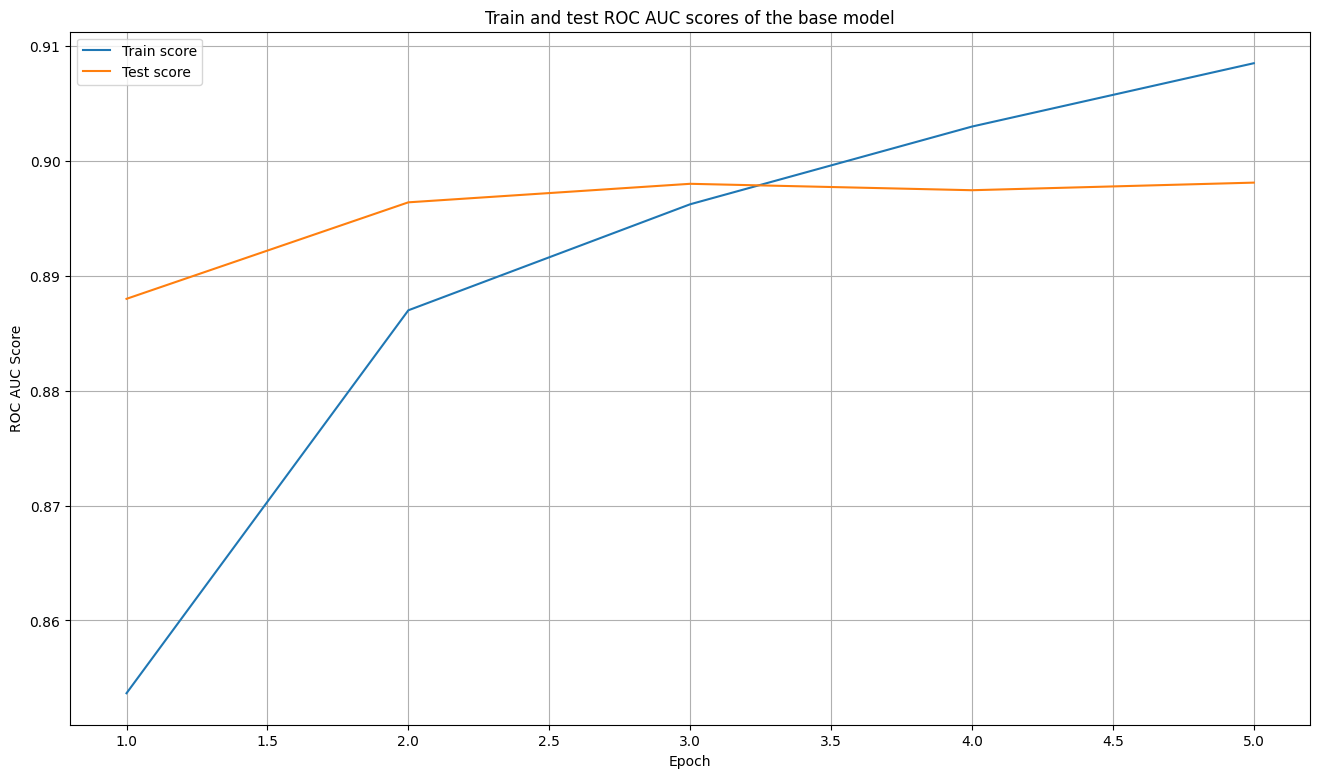

In [33]:
# Plot scores
plot_model_scores(scores_base, 'base model')

## 7.2 Base + Additional layers <a class="anchor" id="chapter_7_2"></a>

In [34]:
# Get train and test scores of every epoch
runtime_base_deep, scores_base_deep = get_model_results('model_base_deep'
                                                          ,get_model_base_deep)

Number of devices: 1
Epoch 1/5
1045/1045 [==============================] - 86s 80ms/step - loss: 0.4881 - auc: 0.8452 - val_loss: 0.4353 - val_auc: 0.8830
Epoch 2/5
1045/1045 [==============================] - 70s 67ms/step - loss: 0.4470 - auc: 0.8719 - val_loss: 0.4228 - val_auc: 0.8868
Epoch 3/5
1045/1045 [==============================] - 75s 72ms/step - loss: 0.4343 - auc: 0.8799 - val_loss: 0.4214 - val_auc: 0.8917
Epoch 4/5
1045/1045 [==============================] - 75s 72ms/step - loss: 0.4306 - auc: 0.8821 - val_loss: 0.4189 - val_auc: 0.8934
Epoch 5/5
1045/1045 [==============================] - 71s 68ms/step - loss: 0.4248 - auc: 0.8855 - val_loss: 0.4255 - val_auc: 0.8904


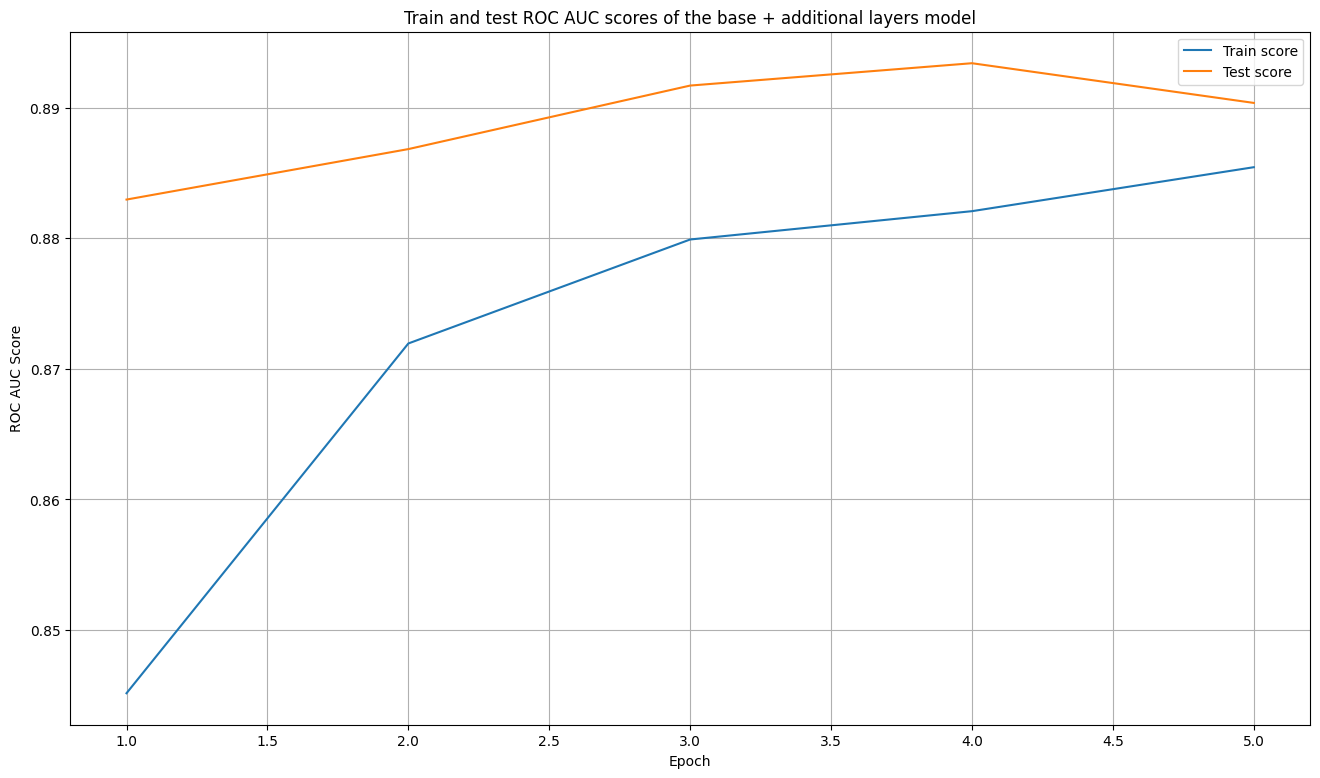

In [36]:
# Plot scores
plot_model_scores(scores_base_deep, 'base + additional layers model')

## 7.3 Base + Wider layers <a class="anchor" id="chapter_7_3"></a>

In [37]:
# Get train and test scores of every epoch
runtime_base_wide, scores_base_wide = get_model_results('model_base_wide'
                                                          ,get_model_base_wide)

Number of devices: 1
Epoch 1/5
1045/1045 [==============================] - 135s 127ms/step - loss: 0.4906 - auc: 0.8475 - val_loss: 0.4677 - val_auc: 0.8716
Epoch 2/5
1045/1045 [==============================] - 79s 76ms/step - loss: 0.4414 - auc: 0.8774 - val_loss: 0.4507 - val_auc: 0.8810
Epoch 3/5
1045/1045 [==============================] - 76s 73ms/step - loss: 0.4252 - auc: 0.8868 - val_loss: 0.4206 - val_auc: 0.8897
Epoch 4/5
1045/1045 [==============================] - 74s 70ms/step - loss: 0.4119 - auc: 0.8942 - val_loss: 0.4215 - val_auc: 0.8919
Epoch 5/5
1045/1045 [==============================] - 72s 69ms/step - loss: 0.3919 - auc: 0.9047 - val_loss: 0.4178 - val_auc: 0.8934


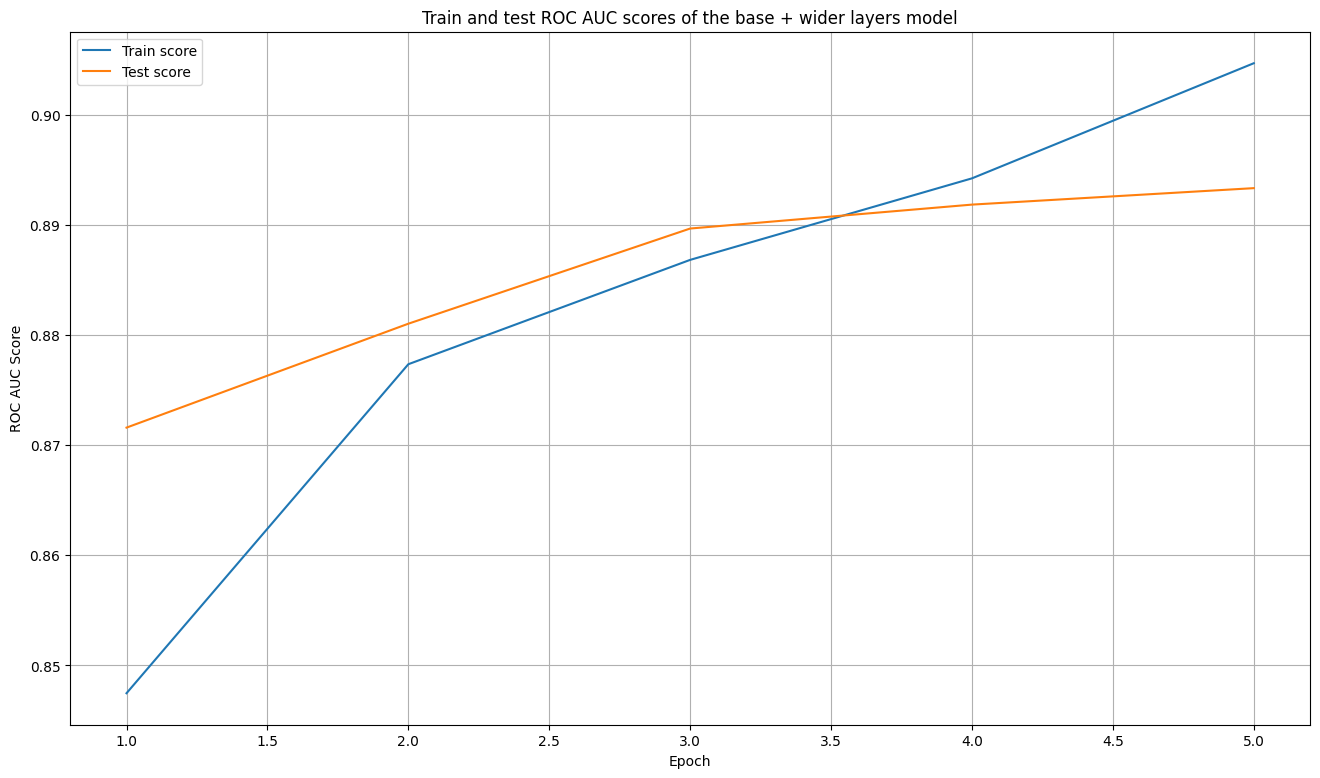

In [38]:
# Plot scores
plot_model_scores(scores_base_wide, 'base + wider layers model')

## 7.4 Base + Max pooling <a class="anchor" id="chapter_7_4"></a>

In [39]:
# Get train and test scores of every epoch
runtime_base_maxpool, scores_base_maxpool = get_model_results('model_base_maxpool'
                                                                ,get_model_base_maxpool)

Number of devices: 1
Epoch 1/5
1045/1045 [==============================] - 74s 69ms/step - loss: 0.4860 - auc: 0.8473 - val_loss: 0.4427 - val_auc: 0.8759
Epoch 2/5
1045/1045 [==============================] - 74s 71ms/step - loss: 0.4389 - auc: 0.8778 - val_loss: 0.4146 - val_auc: 0.8920
Epoch 3/5
1045/1045 [==============================] - 76s 72ms/step - loss: 0.4166 - auc: 0.8909 - val_loss: 0.4040 - val_auc: 0.8997
Epoch 4/5
1045/1045 [==============================] - 71s 68ms/step - loss: 0.4056 - auc: 0.8972 - val_loss: 0.4152 - val_auc: 0.9020
Epoch 5/5
1045/1045 [==============================] - 71s 68ms/step - loss: 0.3979 - auc: 0.9013 - val_loss: 0.3937 - val_auc: 0.9046


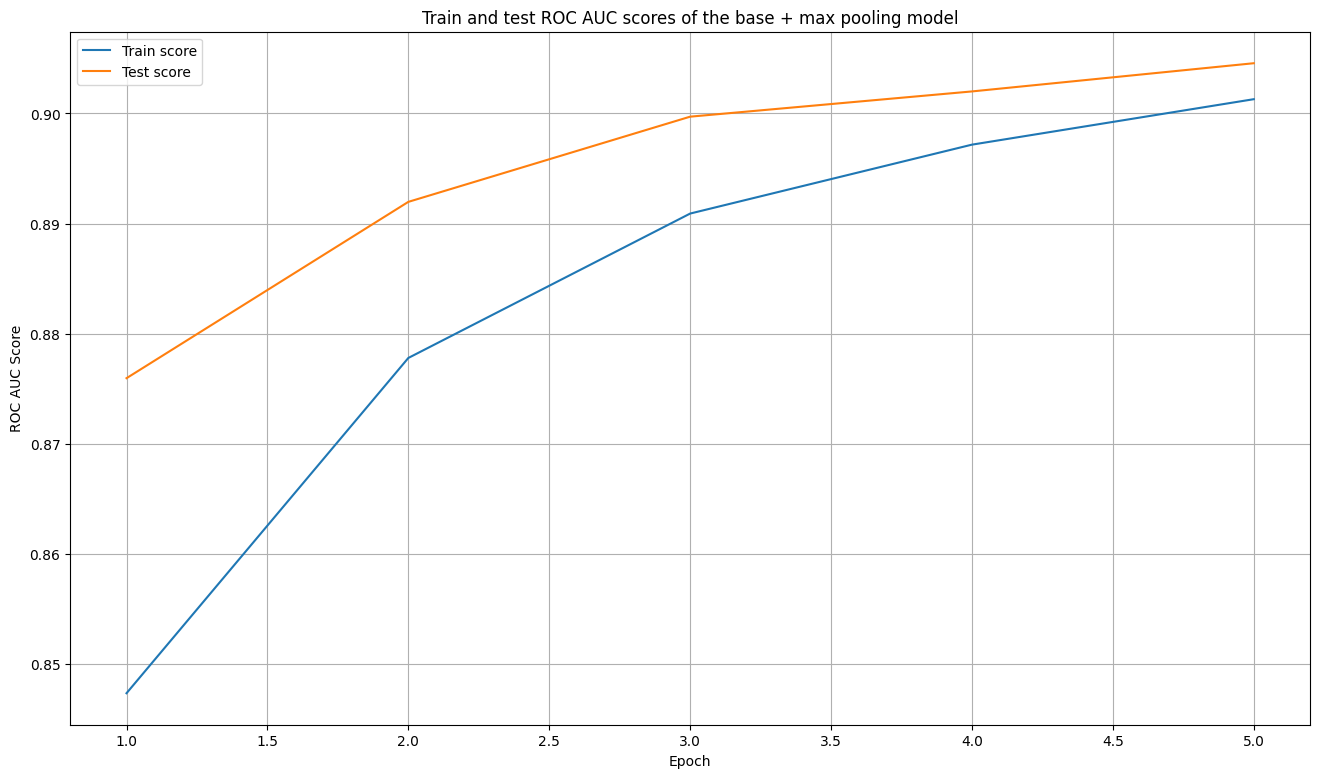

In [40]:
# Plot scores
plot_model_scores(scores_base_maxpool, 'base + max pooling model')

## 7.5 Base + Dropout regularization <a class="anchor" id="chapter_7_5"></a>

In [41]:
# Get train and test scores of every epoch
runtime_base_dropout, scores_base_dropout = get_model_results('model_base_dropout'
                                                                ,get_model_base_dropout)

Number of devices: 1
Epoch 1/5
1045/1045 [==============================] - 73s 68ms/step - loss: 0.4923 - auc: 0.8433 - val_loss: 0.4457 - val_auc: 0.8828
Epoch 2/5
1045/1045 [==============================] - 73s 70ms/step - loss: 0.4472 - auc: 0.8739 - val_loss: 0.4296 - val_auc: 0.8900
Epoch 3/5
1045/1045 [==============================] - 72s 68ms/step - loss: 0.4296 - auc: 0.8853 - val_loss: 0.4141 - val_auc: 0.8929
Epoch 4/5
1045/1045 [==============================] - 69s 66ms/step - loss: 0.4142 - auc: 0.8941 - val_loss: 0.4211 - val_auc: 0.8935
Epoch 5/5
1045/1045 [==============================] - 70s 67ms/step - loss: 0.4094 - auc: 0.8970 - val_loss: 0.4142 - val_auc: 0.8935


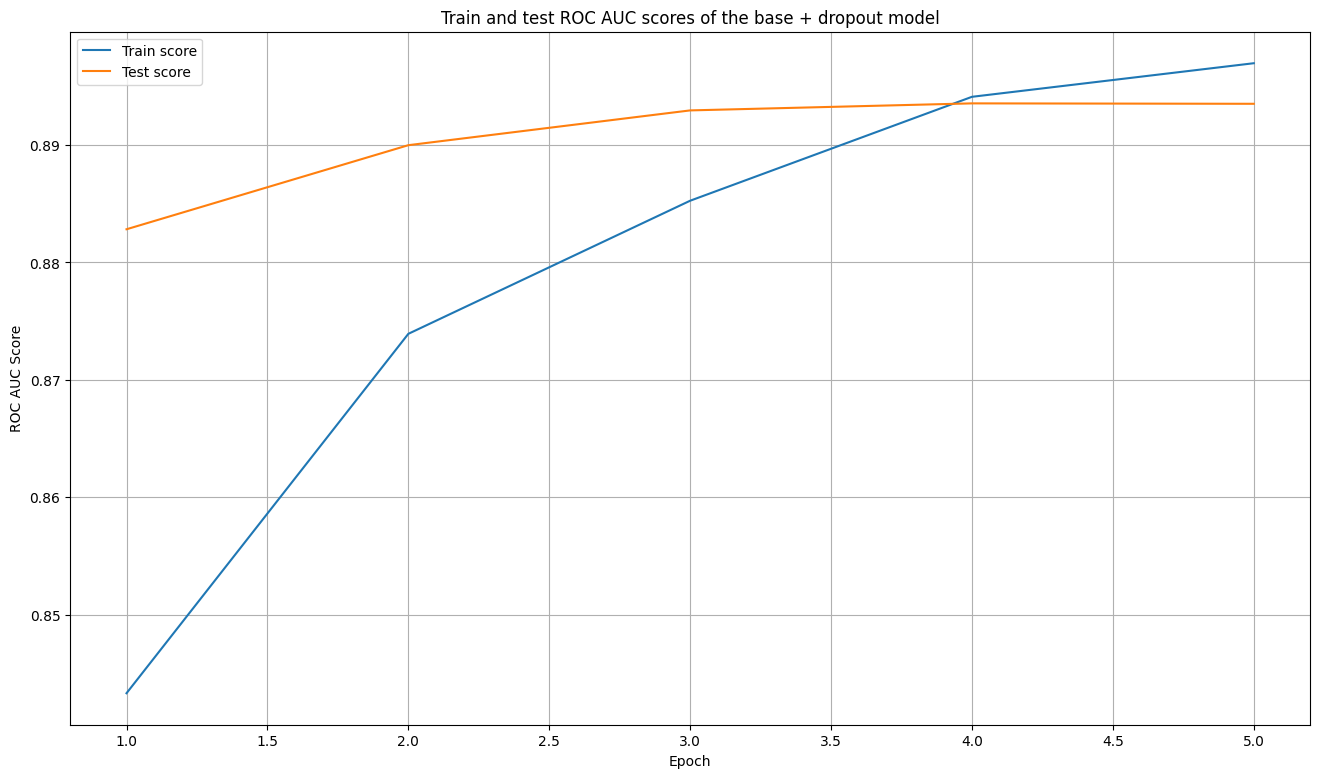

In [42]:
# Plot scores
plot_model_scores(scores_base_dropout, 'base + dropout model')

## 7.6 Table results comparison <a class="anchor" id="chapter_7_6"></a>

The winner among selected models is the 'Base + Max pooling' with the highest test ROC AUC score (0.905) and the second best runtime (378 seconds).<br/>
Here are the possible explanations of the model results in comparison to the 'Base' model in a sorted descending order by test ROC AUC score:
1. **Base + Max pooling:**<br/>
The addition of max pooling layers improved both training and test ROC AUC scores, indicating better performance in capturing complex patterns in the data. The reduced runtime via max pooling apparently helped in reducing the model complexity and surprisingly even improving performance.
2. **Base:**<br/>
The base model, while having the highest training ROC AUC score, showed signs of overfitting as the test ROC AUC score was lower. The longer runtime indicates that this model is more computationally expensive in comparison to others due to the lack of optimization hyperparameters.
3. **Base + Dropout:**<br/>
The addition of dropout layers helped in reducing overfitting as seen by the closer train and test ROC AUC scores. It also made this model the fastest to train. The reason behind these results migh be that dropout layers improved generalization by preventing the model from relying too much on specific features during training.
4. **Base + Wider layers:**<br/>
Increasing units in the dense layers only showed improvement in the runtime. Both train and test ROC AUC scores were lower, indicating that widening the layers did not capture more relevant features.
5. **Base + Additional layers:**<br/>
Again, the improvement was only in the runtime. The scores were the lowest among others, suggesting that the increased depth of the 'Base' model didn't help in learning necessary image features.

In [6]:
# Print table results comparison
results = [('Base', runtime_base, scores_base)
          ,('Base + Add. layers', runtime_base_deep, scores_base_deep)
          ,('Base + Wider layers', runtime_base_wide, scores_base_wide)
          ,('Base + Max pooling', runtime_base_maxpool, scores_base_maxpool)
          ,('Base + Dropout', runtime_base_dropout, scores_base_dropout)]
table = []
for i in range(len(results)):
    tmp = {
            'model': results[i][0]
            , 'runtime (sec)': results[i][1]
            , 'train_roc_auc_score': results[i][2][0][-1]
            , 'test_roc_auc_score': results[i][2][1][-1]
        }
    table.append(tmp)


pd.DataFrame(table).sort_values(by = ['test_roc_auc_score'
                                      ,'runtime (sec)']
                                , ascending = [False, True])

,model,runtime (sec),train_roc_auc_score,test_roc_auc_score
3,Base + Max pooling,377.833386,0.901298,0.904566
0,Base,983.952355,0.908501,0.898109
4,Base + Dropout,368.628719,0.896961,0.893507
2,Base + Wider layers,436.345085,0.904702,0.893355
1,Base + Add. layers,384.274922,0.885454,0.890380


In [51]:
# Cleaning
del results, tmp, table, train_dataset, test_dataset, train_data, train_dir, test_dir
del get_model_results, plot_model_scores, get_compiled_model

# 8. Submission Results <a class="anchor" id="chapter_8"></a>

### Public score: 0.8156
This the ROC AUC score our top performance model, Base + Max pooling, got during submission evaluation.

In [45]:
# Load top performed model
model = load_model('model_base_maxpool.h5')

In [46]:
# Create prefethed dataset of images to classify
submis_data = test_dir + sample_data['id'] + '.tif'
submis_data = submis_data.values

submis_dataset = get_prefetched_data((submis_data)
                                    , BATCH_SIZE)


In [47]:
# Set results
results = model.predict(submis_dataset)

449/449 [==============================] - 258s 573ms/step


In [48]:
# Create table of ids and labels like sample_submission
sample_data['label'] = np.ravel(np.round(results))

In [49]:
# Print submission table
sample_data

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1.0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.0
3,2c35657e312966e9294eac6841726ff3a748febf,0.0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0.0
57454,6f3977130212641fd5808210015a609c658dcbff,0.0
57455,46935f247278539eca74b54d07d666efb528a753,0.0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0.0


In [50]:
# Make submission
sample_data.to_csv('submission.csv', index=False)

In [52]:
# Cleaning
del submis_data, submis_dataset, sample_data
del get_decoded_image, get_prefetched_data

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

In this study, we examined the impact of different architectures and hyperparameters on the performance of convolutional neural network (CNN) models. The comparative analysis was based on the problem of identifying metastatic cancer in small image patches taken from larger digital pathology scans.

The selected methods were:
* Addition of convolutional and dense layers
* Change in the width of layers
* Max pooling introduction
* Dropout regularization

To explore the effects of these configurations on the model we created 5 models: 1 base model and 4 updated. The updated models followed the base model architecture and were independent of each other.

The collected results showed that the addition of max pooling layer proved to be a key factor in enhancing the model's predictive performance while simultaneously reducing computational complexity.<br/>
The introduced regularization technique, the dropout layer, was effective in mitigating overfitting and provided the greatest increase in the model training speed.<br/>
Wider layers and increased depth while being considered as the main hyperparameters to improve model quality overall, happened to be of least importance. In both cases their models scored lower than the base one. The only improvement they showed was the total runtime.

These findings provide brief insights into the interplay between design and model performance. While they underscore the crucial role of thoughtful architecture and hyperparameter tuning, they do not definitively specify which options to exclude. Several other parameters, including learning rate, strides, batch normalization, and others, were not covered in this study. Therefore, additional research on their effects is necessary before establishing an extensive and complex network.

# 10. References <a class="anchor" id="chapter_10"></a>

* Better performance with the tf.data API<br/>
https://www.tensorflow.org/guide/data_performance
* Distributed training with Tensorflow<br/>
https://www.tensorflow.org/guide/distributed_training
* Tensorflow GPU</br>
https://www.tensorflow.org/guide/gpu
* Tensorflow TPU<br/>
https://www.tensorflow.org/guide/tpu